In [51]:
!pip install nltk
!pip install pronouncing

In [52]:
import numpy as np
import pandas as pd
import os
import re
import random
import pronouncing #wrapper around cmu_dict
from collections import Counter

In [53]:
!wget https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/shakespeare.txt
!wget https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/Syllable_dictionary.txt
!wget https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/spenser.txt

--2022-03-10 11:29:37--  https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100643 (98K) [text/plain]
Saving to: ‘shakespeare.txt.1’

shakespeare.txt.1   100%[===================>]  98.28K  --.-KB/s    in 0.009s  

2022-03-10 11:29:38 (10.2 MB/s) - ‘shakespeare.txt.1’ saved [100643/100643]

--2022-03-10 11:29:38--  https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/Syllable_dictionary.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.13

# Helper functions

HMM.py

In [54]:
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import time

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.

            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.

            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.

                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):
            if iteration % 10 == 0:
                print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                    
                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

HMM_helper.py

In [55]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            #word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


class Utility:
    '''
    Utility for the problem files.
    '''

    def __init__():
        pass

    @staticmethod
    def load_sequence(n):
        '''
        Load the file 'sequence_data<n>.txt' for a given n.
        Arguments:
            n:          Sequence index.
        Returns:
            A:          The transition matrix.
            O:          The observation matrix.
            seqs:       Input sequences.
        '''
        A = []
        O = []
        seqs = []

        # For each file:
        with urllib.request.urlopen(f'https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/psets/set6/data/sequence_data{n}.txt') as f:
            # Read the parameters.
            L, D = [int(x) for x in f.readline().decode('utf-8').strip().split('\t')]

            # Read the transition matrix.
            for i in range(L):
                A.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # Read the observation matrix.
            for i in range(L):
                O.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # The rest of the file consists of sequences.
            while True:
                seq = f.readline().decode('utf-8').strip()
                if seq == '':
                    break
                seqs.append([int(x) for x in seq])

        return A, O, seqs

    @staticmethod
    def load_ron():
        '''
        Loads the file 'ron.txt'.
        Returns:
            moods:      Sequnces of states, i.e. a list of lists.
                        Each sequence represents half a year of data.
            mood_map:   A hash map that maps each state to an integer.
            genres:     Sequences of observations, i.e. a list of lists.
                        Each sequence represents half a year of data.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods = []
        mood_map = {}
        genres = []
        genre_map = {}
        mood_counter = 0
        genre_counter = 0

        with urllib.request.urlopen("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/psets/set6/data/ron.txt") as f:
            mood_seq = []
            genre_seq = []

            while True:
                line = f.readline().decode('utf-8').strip()

                if line == '' or line == '-':
                    # A half year has passed. Add the current sequence to
                    # the list of sequences.
                    moods.append(mood_seq)
                    genres.append(genre_seq)
                    # Start new sequences.
                    mood_seq = []
                    genre_seq = []
                
                if line == '':
                    break
                elif line == '-':
                    continue
                
                mood, genre = line.split()
                
                # Add new moods to the mood state hash map.
                if mood not in mood_map:
                    mood_map[mood] = mood_counter
                    mood_counter += 1

                mood_seq.append(mood_map[mood])

                # Add new genres to the genre observation hash map.
                if genre not in genre_map:
                    genre_map[genre] = genre_counter
                    genre_counter += 1

                # Convert the genre into an integer.
                genre_seq.append(genre_map[genre])

        return moods, mood_map, genres, genre_map

    @staticmethod
    def load_ron_hidden():
        '''
        Loads the file 'ron.txt' and hides the states.
        Returns:
            genres:     The observations.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods, mood_map, genres, genre_map = Utility.load_ron()

        return genres, genre_map

# Pre-Processing

## Getting Syllable Dictionary

In [56]:
# Getting syllable dictionary
# syllable_dict[word] is a list, 
# syllable_dict[word][0] is a list of possible numbers of syllables
# syllable_dict[word][1] is #syllables at end of line
# for example, beloved 2 3 --> syllable_dict['beloved'] = [[2,3], -1]
#              better E1 2 --> syllable_dict['better'] = [[2], 1]
#              behold 2    --> syllable_dict['behold'] = [[2], -1]

syllable_dict = {}

file = open('Syllable_dictionary.txt', 'r')
lines = file.readlines()

for line in lines:
    line = line.split()
    norm = []
    end = -1
    for syl in line[1:]:
        if syl[0] == 'E':
            end = int(syl[1])
        else:
            norm.append(int(syl))
    syllable_dict[line[0]] = [norm, end]

# check if right
syllable_dict['beloved'], syllable_dict['better'], syllable_dict['behold']

([[2, 3], -1], [[2], 1], [[2], -1])

In [57]:
def clean_data(raw_text):
    # remove captial letters
    clean_text = raw_text.lower()

    # remove leading and trailing white spaces
    clean_text = clean_text.strip()

    # remove number indices
    clean_text = ''.join(i for i in clean_text if not i.isdigit())

    # remove the following punctuations, keep ' and -
    clean_text = re.sub("[!?.,:;()]", "", clean_text)

    # remove extra spacing
    clean_text = re.sub(r'(\n\s*)+\n', '\n\n', clean_text)

    # remove unwanted apostrophe
    clean_text = clean_text.replace("' "," ").replace(" '", " ")
    clean_text = clean_text.replace("'\n","\n").replace("\n'", "\n")

    # clean_text = clean_text.replace(" gainst ", " 'gainst ")
    # clean_text = clean_text.replace(" greeing ", " 'greeing ")
    # clean_text = clean_text.replace(" scaped ", " 'scaped ")
    # clean_text = clean_text.replace(" tis ", " 'tis ")
    # clean_text = clean_text.replace(" twixt ", " 'twixt ")
    # clean_text = clean_text.replace(" t ", " t' ")
    # clean_text = clean_text.replace(" th ", " th' ")
    return clean_text


def check_apostrophe(word):
    '''
    return false if the apostrophe is used as a quotation mark and can be deleted
    return true if the apostrophe should be kept 
    '''
    if word[0] == "'" or word[-1] == "'" and word not in syllable_dict:
            return False
    return True

raw_text = open('shakespeare.txt').read()
clean_text = clean_data(raw_text)

# Unsupervised Learning
Create HMM for poem generation

In [58]:
obs, obs_map = parse_observations(clean_text)

obs_map["'gainst"] = obs_map.pop("gainst")
obs_map["'greeing"] = obs_map.pop("greeing")
obs_map["'scaped"] = obs_map.pop("scaped")
obs_map["'twixt"] = obs_map.pop("twixt")
obs_map["'tis"] = obs_map.pop("tis")
obs_map["t'"] = obs_map.pop("t")
obs_map["th'"] = obs_map.pop("th")

obs_map_rev = obs_map_reverser(obs_map)



hmm4 = unsupervised_HMM(obs, 4, 20)

Iteration: 10
Iteration: 20


sanity check

In [59]:
syl_dict_words = set(syllable_dict.keys())
shake_words = set(obs_map.keys())
shake_and_not_syl_dict_words = shake_words - syl_dict_words
print(len(shake_words))
print(len(shake_and_not_syl_dict_words))
print(shake_and_not_syl_dict_words)

3205
0
set()


# Poetry Generation, Part 1: Hidden Markov Models

This function needs to be revised to make sure that the sonnet has exactly 10 syllables. Currently it most likely will be but we might wanna change it

In [60]:
def generate_sonnet(hmm, obs_map_rev):
    '''
    Generates a sonnet with 10 syllables. Modified from generate_emission function from set 6

    Arguments:
        hmm:            trained HMM
        obs_map_rev:    reversed map of observations
    
    Returns:
        sonnet:         the randomly generated sonnet as a string
    '''

    sonnet = []
    syllable_count = 0
    syllable_max = 10

    emission = []
    state = random.choice(range(hmm.L))
    states = []

    while syllable_count < syllable_max:
        # Append state.
        states.append(state)

        # Sample next observation.
        rand_var = random.uniform(0, 1)
        next_obs = 0

        while rand_var > 0:
            rand_var -= hmm.O[state][next_obs]
            next_obs += 1

        next_obs -= 1
        word = obs_map_rev[next_obs]
        
        emission.append(next_obs)
        syllable_count += syllable_dict[word][0][0]
        sonnet.append(word)

        # Sample next state.
        rand_var = random.uniform(0, 1)
        next_state = 0

        while rand_var > 0:
            rand_var -= hmm.A[state][next_state]
            next_state += 1

        next_state -= 1
        state = next_state

    return sonnet, states, emission


In [61]:
sonnet,_,_ = generate_sonnet(hmm4, obs_map_rev)
print(sonnet)
for i in sonnet:
    print(syllable_dict[i])

['the', 'self', 'but', 'take', 'as', 'what', "'tis", 'see', 'without']
[[1], -1]
[[1], -1]
[[1], -1]
[[1], -1]
[[1], -1]
[[1], -1]
[[1], -1]
[[1], -1]
[[2], -1]


In [62]:
# generating full 14-line sonnet
for l in range(14):
  line, _,_ = generate_sonnet(hmm4, obs_map_rev)
  print(' '.join(line))

to thee mayst reason as trust out all of
my dark distilled counterfeit receiv'st to
dwell things nurseth would me and they redeem
false youth beauty's and friend doth in time this
more mad is do now but need self my thy
but are roses whence heart like and i able
which flame my know through not they weeds thus thy
for i my pure too i of thee dear she
who ill fair self mak'st heart art thou of beauty
me i beauty hold abysm still to but
be flame and and art song eyes and with ornament
but shalt before your eyes and of waste to
every acknowledge hast in me walls is
admit green to power the eyes a thee doth


### Number of Hidden States
Takes a long time to run

In [ ]:
for st in [1,2,6,10,20,40,60]:
  print('\nSonnet with {} hidden states'.format(st))
  hmm = unsupervised_HMM(obs, st, 20)
  for l in range(14):
    line,_,_ = generate_sonnet(hmm, obs_map_rev)
    print(' '.join(line))


Sonnet with 1 hidden states
Iteration: 10
Iteration: 20
light in complain have like stirred in each birds
by knowing a the for beauty's content
being shall form provide none proud him is love
winds in dead basest be glory read thou
all god that deemed love can even simple on
brought tears thought a suff'ring bars eyes th' lies good
to that either if thy this faults thou my of
in i his a to one birds faults and is
making me short since policy heart growth
other general to done sweet see can your
men's gladly the in bred when times bail self
time's of love know esteemed sad of behold
more green full me who of what clearer all
worthy of brow beauty's often of my

Sonnet with 2 hidden states
Iteration: 10
Iteration: 20
breath thy is lofty blessed all that ever
love where so golden the bereft if sooner
thereof angel that so but my world blunting
o prepare eyes consumed chips preposterously
and askance eternal pale sweet compounded
used think self happy bath upon skill body
that come i thou

## Additional goal: Rhymable word

In [ ]:
def rhymable_word(word,obs_map):

        '''
        Determines if a word has rhymable words according to the cmu dictionary
        and if any of those words are also in the shakesphere cleaned text
        Arguments:
            word:             str
            obs_map:          Word to index dictionary

        Returns:
            Boolean

        '''
        cmu_rhyming_words = set(pronouncing.rhymes(word))
        shake_words = set(obs_map.keys())

        shake_rhyming_words = shake_words & cmu_rhyming_words# intersection

        if len(shake_rhyming_words)==0:
          return False
        else:
          return True

In [ ]:
def generate_syl_emission(hmm,obs_map,obs_map_rev,num_syl):
        '''
        Generates an emission with 10 syllables, assuming that the starting state
        is chosen uniformly at random. Also enforces that the last word use in
        the sequence must be rhymable
        Arguments:
            hmm:              Hidden Markov Model
            obs_map:          Word to index dictionary
            obs_map_rev:      Index to word dictionary 
            num_syl:          Number of syllables in the sequence
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
            sentence:   A string of words corresponding to the emission
        '''
        syl_count = 0
        last_word_rhymable = False
        while syl_count!=num_syl or not last_word_rhymable:
          emission = []
          states = []

          y_options = list(range(hmm.L))
          x_options = list(range(hmm.D))
          O = np.array(hmm.O)
          A = np.array(hmm.A)

          #pick random y
          states.append(np.random.choice(y_options))
          #pick x from self.O
          emission.append(np.random.choice(x_options,p=O[states[0],:]))
        
          syl_count = syllable_dict[obs_map_rev[emission[0]]][0][0]
          for i in range(1,100):
            #pick random y
            states.append(np.random.choice(y_options,p=A[int(states[i-1]),:]))
            #pick x from self.O
            emission.append(np.random.choice(x_options,p=O[int(states[i]),:]))

            next_word_syl = syllable_dict[obs_map_rev[emission[-1]]]

            last_word_rhymable = rhymable_word(obs_map_rev[emission[-1]],obs_map)

            #handle words with 1 syl only at the end of the sequence
            if syl_count+next_word_syl[1]== num_syl:
              break
            syl_count += next_word_syl[0][0]
            if syl_count>=num_syl:
              break
        



        sentence_list = [obs_map_rev[i] for i in emission]
        sentence = ' '.join(sentence_list).capitalize()
        return emission, states, sentence

In [ ]:
def generate_syl_emission_reverse(hmm,obs_map,obs_map_rev, word_ind, num_syl):
        '''
        Generates an emission of length M, given a word the final word of the
        sequence must rhyme with. If no words in the cmu library rhyme with the
        given word, return None
        Arguments:
            hmm:              Hidden Markov Model
            obs_map:          Word to index dictionary
            obs_map_rev:      Index to word dictionary 
            word_ind:         Index of word that  final word of sequence must rhyme with
            num_syl:          Number of syllables in the sequence
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
            sentence:   A string of words corresponding to the emission
        '''

        cmu_rhyming_words = set(pronouncing.rhymes(obs_map_rev[word_ind]))
        shake_words = set(obs_map.keys())

        shake_rhyming_words = shake_words & cmu_rhyming_words# intersection

        if len(shake_rhyming_words)==0:
          print('Something is broken')
          return None

        #convert possible words back to index
        last_word_options = [ obs_map[word] for word in shake_rhyming_words]

        


        state_options = list(range(hmm.L))
        word_options = list(range(hmm.D))
        O = np.array(hmm.O)
        A = np.array(hmm.A)
        A_reverse = A / np.array(A).sum(axis=0)[:]
        A_reverse = A_reverse.T

        syl_count = 0 # need to give some value to syl_count
        while syl_count !=num_syl: # keep looping until it hits 10 syl
          emission = []
          states = []

          #pick random word from list of rhyming words
          emission.append(np.random.choice(last_word_options))

          #calculate probability of y based on this option
          initial_state_prob = O[:,emission[0]] / sum(O[:,emission[0]])

          #pick word randomly from the known rhyming words
          states.append(np.random.choice(state_options, p = initial_state_prob))

          next_word_syl = syllable_dict[obs_map_rev[emission[0]]]

          if next_word_syl[1]!=-1:#special case at end of word
            syl_count = next_word_syl[1]
          else:
            syl_count = next_word_syl[0][0]


          for i in range(1,100):
            #pick random y
            states.insert(0,np.random.choice(state_options,p=A_reverse[int(states[i-1]),:]))
            #pick x from self.O
            emission.insert(0,np.random.choice(word_options,p=O[int(states[i]),:]))

            next_word_syl = syllable_dict[obs_map_rev[emission[0]]]

            syl_count += next_word_syl[0][0]
            if syl_count>=num_syl:
              break

        sentence_list = [obs_map_rev[i] for i in emission]
        sentence = ' '.join(sentence_list).capitalize()
        return emission, states, sentence


In [ ]:
def generate_rhyming_sonnet(hmm,obs_map,obs_map_rev):
  emissions = []
  all_states = []
  sonnet = ''

  #Write all of the quatrains
  for i in range(3):
    emission, states, sentence= generate_syl_emission(hmm,obs_map,obs_map_rev,10)
    a_word_ind = emission[-1]
    sonnet +=sentence+'\n'
    emissions.append(emission)
    all_states.append(states)

    emission, states, sentence= generate_syl_emission(hmm,obs_map,obs_map_rev,10)
    b_word_ind = emission[-1]
    sonnet +=sentence+'\n'
    emissions.append(emission)
    all_states.append(states)

    emission, states, sentence= generate_syl_emission_reverse(hmm,obs_map,obs_map_rev,a_word_ind,10)
    a_word_ind = emission[-1]
    sonnet +=sentence+'\n'
    emissions.append(emission)
    all_states.append(states)

    emission, states, sentence= generate_syl_emission_reverse(hmm,obs_map,obs_map_rev,b_word_ind,10)
    b_word_ind = emission[-1]
    sonnet +=sentence+'\n \n'
    emissions.append(emission)
    all_states.append(states)

  #write Volta
  emission, states, sentence= generate_syl_emission(hmm,obs_map,obs_map_rev,10)
  a_word_ind = emission[-1]
  sonnet +=sentence+'\n'
  emissions.append(emission)
  all_states.append(states)

  emission, states, sentence= generate_syl_emission_reverse(hmm,obs_map,obs_map_rev,a_word_ind,10)
  a_word_ind = emission[-1]
  sonnet +=sentence
  emissions.append(emission)
  all_states.append(states)

  return sonnet, emissions, all_states

In [ ]:
hmm_list =[]
for st in [1,2,6,10]:#,20,30,40,60]:
  hmm = unsupervised_HMM(obs, st, 30)
  hmm_list.append(hmm)
  print('################################')
  print(f'Number of hidden states: {st}')
  sonnet, _, _ = generate_rhyming_sonnet(hmm,obs_map,obs_map_rev)
  print(sonnet)

Iteration: 10
Iteration: 20
Iteration: 30
################################
Number of hidden states: 1
Line so and take trust in transferred is swear
Men thou abuses thou there that looks there
Cold all-oblivious weeds may grieve prove ne'er
Place in and proud her thou sorry of hair
 
Not very canker who jewel strange all
Was should error in swift report shame when
Yet asleep dry to near breeds from thy fall
O thee born oaths self like in bath of pen
 
Dost sweet then must that mine robbery to all
Gold even like to body's dial pleasure
Of feasting still their to thou admire tall
Against why me may mine saint cheater measure
 
The though but by chest muse and again i
Against be my ripe all disgrace the cry
Iteration: 10
Iteration: 20
Iteration: 30
################################
Number of hidden states: 2
I do wonder so forwards me rightly
Proving me praise all sweet he wherein to
Be show blot finger nothing though nightly
Sickle's me still be themes death a leave sue
 
Every this and b

##Aditional Goal: Haiku 

In [ ]:
def generate_haiku(hmm,obs_map,obs_map_rev):
  haiku = ''
  emission, states, sentence= generate_syl_emission(hmm,obs_map,obs_map_rev,5)
  haiku +=sentence+'\n'
  emission, states, sentence= generate_syl_emission(hmm,obs_map,obs_map_rev,7)
  haiku +=sentence+'\n'
  emission, states, sentence= generate_syl_emission(hmm,obs_map,obs_map_rev,5)
  haiku +=sentence+'\n'

  return haiku



In [ ]:
print(generate_haiku(hmm,obs_map,obs_map_rev))

While ornament not
And thy doth more reasons praise
Thou cloud change the your



# Poetry Generation, Part 2: Recurrent Neural Network


Adapted from the following tutorial: https://medium.com/analytics-vidhya/ai-writing-poems-building-lstm-model-using-pytorch-d1c58a24bb64

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
# Map characters to integer
chars = tuple(set(clean_text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
encoded = np.array([char2int[ch] for ch in clean_text])

In [ ]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [ ]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [ ]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=128, n_layers=2,
                               drop_prob=0.2, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        #lstm layer
        self.lstm=nn.LSTM(len(self.chars),n_hidden,n_layers,
                          dropout=drop_prob,batch_first=True)
        
        #dropout layer
        self.dropout=nn.Dropout(drop_prob)
        
        #output layer
        self.fc=nn.Linear(n_hidden,len(self.chars))
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        ## Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## put x through the fully-connected layer
        out = self.fc(out)
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
            weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [ ]:
def train(net, data, epochs=10, batch_size=10, seq_length=150, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    
                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [ ]:
# define and print the net
n_hidden = 128
n_layers = 1

net = CharRNN(chars, n_hidden, n_layers)
print(net)
batch_size = 128
seq_length = 40
n_epochs =  200
# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CharRNN(
  (lstm): LSTM(30, 128, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=30, bias=True)
)
Epoch: 4/200... Step: 50... Loss: 2.8946... Val Loss: 2.9235
Epoch: 7/200... Step: 100... Loss: 2.8111... Val Loss: 2.8324
Epoch: 10/200... Step: 150... Loss: 2.5992... Val Loss: 2.6320
Epoch: 13/200... Step: 200... Loss: 2.4218... Val Loss: 2.4903
Epoch: 16/200... Step: 250... Loss: 2.3175... Val Loss: 2.3979
Epoch: 19/200... Step: 300... Loss: 2.2392... Val Loss: 2.3365
Epoch: 22/200... Step: 350... Loss: 2.2179... Val Loss: 2.2907
Epoch: 25/200... Step: 400... Loss: 2.2352... Val Loss: 2.2560
Epoch: 29/200... Step: 450... Loss: 2.1283... Val Loss: 2.2260
Epoch: 32/200... Step: 500... Loss: 2.1123... Val Loss: 2.2028
Epoch: 35/200... Step: 550... Loss: 2.1136... Val Loss: 2.1768
Epoch: 38/200... Step: 600... Loss: 2.0440... Val Loss: 2.1509
Epoch: 41/200... Step: 650... Loss: 2.0024... Val Loss: 2.1283
Epoch: 44/200..

In [ ]:
def predict(net, char, h=None, temperature=1):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)
        # get the character probabilities
        p = F.softmax(out/temperature, dim=1).data

        # get top characters
        top_k = len(p[0])
        p, top_ch = p.topk(top_k)
        top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        if p.size==1:
            char = int(top_ch)
        else:
            char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

def sample(net, size, prime='The', temperature=1):
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, temperature)
    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, temperature)
        chars.append(char)
    return ''.join(chars)

In [ ]:
print(sample(net, 200, prime='shall i compare thee to a summers day\n', temperature=1.5))

shall i compare thee to a summers day
which shalt zighance beform-sbcat untespect
yad herarde's thighinf say true
by phayof 
waldn  bramkedmlinds no oulfingermegit when my shame
age with varest kieddo hangingncing ind ere
a
aede'a you two 


In [ ]:
print(sample(net, 200, prime='shall i compare thee to a summers day\n', temperature=0.75))

shall i compare thee to a summers day
the tome be i spor's by my summin's now
to thange mare i love thou warth thee goth my sow
  sumior that thy self true borthe wick
so hat the stain to duts the wlesper such only
but heaven far look on t


In [ ]:
print(sample(net, 200, prime='shall i compare thee to a summers day\n', temperature=0.5))

shall i compare thee to a summers day
that sel her thee thou art the iser with prowing hath love
the tan seeplows thou art now i happe them
as i my sove comber the commer will his light
and thy beauty moring one mine eye
that he con the wi


In [ ]:
print(sample(net, 200, prime='shall i compare thee to a summers day\n', temperature=0.25))

shall i compare thee to a summers day
and thought thou the thence thou shall stall tormen shall still
  for the to the bour of love that which still and thee
  that thou whose shall his grace my sulf all mes in thee
  and thee the will of 


# Visualization + Interpretation

## Top 10 words associated with a hidden state
#### From initial method HMM, not improved

In [ ]:
# generating many sonnets and accumulating the data for given hmm, using rhyming sonnet
hmm = unsupervised_HMM(obs, 10, 20)

emissions = []
states = []
for n in range(500):
  _, state, emission = generate_sonnet(hmm, obs_map_rev)
  emissions.append(emission)
  states.append(state)

# flatten lists
flat_st = [item for sublist in states for item in sublist]
flat_emiss = [item for sublist in emissions for item in sublist]

Iteration: 10
Iteration: 20


Counter({'of': 78, 'in': 57, 'my': 56, 'be': 24, 'so': 23, 'is': 22, 'as': 9, 'and': 9, 'hath': 8, 'sweet': 8, 'doth': 7, 'or': 6, 'for': 6, 'which': 6, 'from': 6, 'by': 6, 'to': 6, 'not': 5, 'set': 5, 'were': 5, 'thy': 5, 'but': 5, 'than': 5, "beauty's": 4, 'wait': 4, 'what': 4, 'self': 4, 'with': 4, 'being': 4, 'hold': 3, 'another': 3, 'upon': 3, 'dear': 3, 'yet': 3, 'before': 3, 'matter': 3, 'was': 3, 'that': 3, 'memory': 3, 'might': 3, 'quite': 3, 'welcome': 2, 'shade': 2, 'speak': 2, 'almost': 2, "feel'st": 2, 'plods': 2, 'true': 2, 'renew': 2, 'read': 2, 'your': 2, 'abundance': 2, 'wet': 2, 'assured': 2, 'life': 2, 'am': 2, 'let': 2, 'control': 2, 'fair': 2, 'keep': 2, 'face': 2, 'gay': 2, 'may': 2, 'medicine': 2, 'presenteth': 2, 'send': 2, 'audit': 2, 'rhyme': 2, 'reasons': 2, 'beauteous': 2, 'glass': 2, 'outward': 2, "o'ertake": 2, 'without': 2, 'back': 2, 'black': 2, 'add': 2, 'bring': 2, 'the': 2, 'predict': 1, 'eyes': 1, 'seeking': 1, 'inherit': 1, 'new': 1, 'affable': 1, '

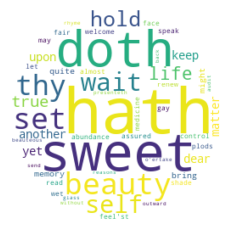

Counter({'that': 16, 'as': 16, 'when': 13, 'and': 12, 'if': 12, 'on': 8, 'my': 8, 'for': 7, 'though': 6, 'or': 5, 'mine': 5, 'to': 4, 'happy': 4, 'what': 4, 'then': 3, 'which': 3, 'since': 3, 'great': 3, 'take': 3, 'why': 3, 'at': 2, 'unless': 2, 'hearts': 2, 'whom': 2, 'cannot': 1, 'still': 1, 'me': 1, 'losing': 1, 'distilled': 1, "man's": 1, 'after': 1, 'far': 1, 'shall': 1, 'may': 1, 'pleasure': 1, 'repair': 1, 'sightless': 1, 'this': 1, 'yet': 1, 'large': 1, 'compare': 1, 'thee': 1, 'long': 1, 'made': 1, 'store': 1, 'give': 1, "o'erpressed": 1, 'true': 1, 'things': 1, 'hath': 1, 'how': 1, 'veins': 1, 'because': 1, 'alters': 1, 'let': 1, 'anon': 1, 'provoke': 1, 'travelled': 1, 'bold': 1, 'purpose': 1, 'soon': 1, 'although': 1, 'not': 1, 'three': 1, 'bones': 1, 'use': 1, 'you': 1, 'i': 1, 'deemed': 1, 'before': 1, 'can': 1, 'borne': 1, 'had': 1, 'being': 1, 'deep': 1, 'no': 1, 'render': 1, 'importune': 1, 'so': 1, 'strength': 1, 'one': 1, 'fair': 1})


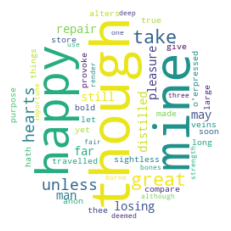

Counter({'and': 11, 'o': 5, 'but': 4, 'when': 3, 'for': 3, 'that': 2, 'or': 2, 'so': 1, 'stealing': 1, 'lascivious': 1, 'than': 1, 'tibey': 1, 'who': 1, 'weighs': 1, 'proving': 1, 'whereto': 1, 'nor': 1, 'vaunt': 1, "what's": 1, 'commanded': 1, "o'ercharged": 1, 'theirs': 1, 'yet': 1, 'past': 1, 'whilst': 1, 'wishing': 1, 'save': 1, 'admit': 1, 'askance': 1, 'sword': 1, 'ay': 1})


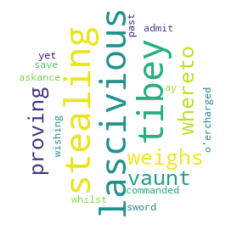

Counter({'i': 46, 'not': 29, 'that': 27, 'me': 18, 'have': 17, 'to': 17, 'with': 16, 'do': 14, 'doth': 13, 'more': 12, 'might': 10, 'see': 10, 'they': 10, 'can': 9, 'no': 8, 'so': 8, 'am': 8, 'did': 7, 'in': 7, 'dost': 6, 'love': 6, 'thee': 6, 'make': 6, 'are': 5, 'now': 5, 'is': 5, 'from': 4, 'it': 4, 'eyes': 4, 'know': 4, 'thou': 4, 'wilt': 4, 'stand': 4, 'dare': 4, 'some': 3, 'art': 3, 'shall': 3, 'give': 3, 'shalt': 3, 'kill': 3, 'fears': 3, 'mayst': 3, 'write': 3, 'she': 3, 'well': 3, 'pen': 3, 'should': 3, 'win': 3, 'yet': 3, 'writ': 3, 'say': 2, 'he': 2, 'err': 2, 'still': 2, 'replete': 2, 'you': 2, 'swear': 2, 'prove': 2, 'seen': 2, 'show': 2, 'steal': 2, 'figured': 2, 'hath': 2, 'ensconce': 2, 'freezings': 2, 'bear': 2, 'for': 2, 'says': 2, 'my': 2, 'ever': 2, 'hear': 2, 'flowers': 2, 'end': 2, 'pitying': 2, 'devise': 2, 'hast': 2, 'beauty': 2, 'which': 2, "o'er": 2, 'imitate': 2, 'base': 2, 'most': 2, 'how': 2, 'been': 2, 'never': 2, 'die': 2, 'although': 2, 'we': 1, 'impute'

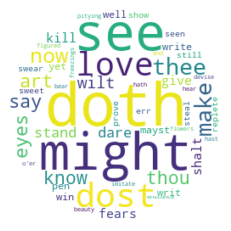

Counter({'thy': 53, 'a': 25, 'love': 21, 'that': 20, 'this': 19, 'my': 18, 'your': 17, 'mine': 13, 'on': 11, 'self': 10, 'it': 10, 'me': 9, 'thine': 8, 'beauty': 6, 'heart': 6, 'friend': 6, 'still': 6, "love's": 5, 'an': 5, 'thee': 5, 'be': 5, 'night': 4, 'sight': 4, 'hate': 4, 'now': 4, 'praise': 4, 'and': 4, 'is': 4, 'life': 4, 'large': 4, 'such': 4, 'best': 3, 'mistress': 3, 'born': 3, 'bad': 3, 'shows': 3, 'long': 3, 'shall': 3, 'will': 3, 'you': 3, 'black': 3, 'are': 3, 'her': 3, 'had': 3, 'words': 3, 'twenty': 3, 'verse': 3, 'truth': 3, 'false': 2, 'most': 2, 'music': 2, 'gone': 2, 'image': 2, 'time': 2, 'poor': 2, 'imperfect': 2, 'growth': 2, 'fire': 2, 'great': 2, 'kind': 2, 'again': 2, 'sure': 2, 'hope': 2, 'i': 2, 'him': 2, 'arise': 2, 'face': 2, 'heaven': 2, 'strong': 2, 'far': 2, 'flame': 2, 'at': 2, 'blessings': 2, 'stain': 2, 'motion': 2, 'shape': 2, 'compounded': 2, 'honour': 2, 'stage': 2, 'public': 2, 'use': 2, 'grounded': 2, 'into': 2, 'weeds': 2, 'birth': 2, 'down': 

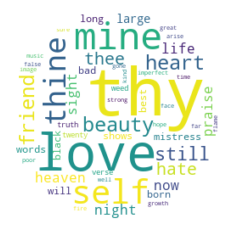

Counter({'i': 37, 'thou': 35, 'to': 16, 'and': 13, 'eye': 12, 'eyes': 10, 'a': 10, 'heart': 9, 'you': 9, 'away': 7, 'it': 5, 'which': 4, 'time': 4, 'new': 4, 'right': 4, 'for': 4, 'ill': 4, 'shall': 4, 'more': 4, 'sense': 4, 'part': 4, 'full': 3, 'doth': 3, 'name': 3, 'fair': 3, 'there': 3, 'wrong': 3, 'will': 3, 'dead': 3, 'sake': 3, 'days': 3, 'his': 3, 'thee': 3, 'what': 3, 'beauty': 3, 'sum': 3, 'looks': 3, 'be': 2, 'told': 2, 'though': 2, 'warmed': 2, 'face': 2, 'five': 2, 'should': 2, 'sin': 2, 'inward': 2, 'loss': 2, 'birth': 2, 'love': 2, 'untrue': 2, 'against': 2, 'purpose': 2, 'could': 2, "ne'er": 2, 'depart': 2, 'are': 2, 'jacks': 2, 'hell': 2, 'ink': 2, 'respect': 2, 'pleasure': 2, 'knows': 2, 'before': 2, 'triumph': 2, 'allow': 2, 'bier': 2, 'bonds': 2, 'invention': 2, 'deserts': 2, 'slander': 2, 'speak': 2, 'is': 2, 'roses': 2, 'least': 2, 'huge': 2, 'now': 2, "o'erlook": 2, 'bed-vow': 2, 'muse': 2, 'from': 2, 'outworn': 2, 'darkness': 2, 'not': 2, 'as': 2, 'turns': 2, "r

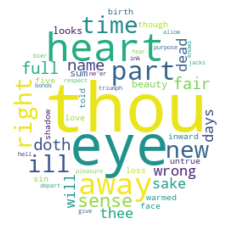

Counter({'the': 72, 'all': 17, 'thee': 16, 'their': 12, 'thou': 9, 'such': 8, 'old': 7, 'his': 7, 'thy': 7, 'my': 7, 'that': 6, 'grew': 5, 'this': 5, 'if': 5, 'nothing': 5, 'me': 5, 'when': 5, 'what': 5, 'had': 4, 'of': 4, 'her': 4, 'to': 4, 'time': 4, 'kept': 3, 'faith': 3, 'our': 3, 'taught': 3, 'like': 3, 'will': 3, 'one': 3, 'find': 3, 'any': 3, 'many': 3, 'no': 3, 'these': 3, 'at': 3, 'your': 3, 'by': 2, 'those': 2, 'lie': 2, 'two': 2, 'busy': 2, 'wounded': 2, 'good': 2, 'give': 2, 'for': 2, 'beauteous': 2, 'very': 2, 'sorrow': 2, 'a': 2, 'longer': 2, 'are': 2, 'light': 2, 'just': 2, 'not': 2, 'each': 2, 'fresh': 2, 'deeds': 1, 'still': 1, 'tender': 1, 'watch': 1, 'threescore': 1, 'decay': 1, 'now': 1, 'excuse': 1, 'other': 1, 'black': 1, 'minds': 1, 'errors': 1, 'them': 1, 'temperate': 1, "learned's": 1, 'small': 1, 'account': 1, 'on': 1, 'shall': 1, 'scope': 1, 'fill': 1, 'perfect': 1, 'and': 1, 'suit': 1, 'slow': 1, 'urge': 1, 'wont': 1, 'times': 1, 'stones': 1, 'with': 1, 'lea

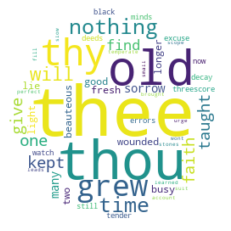

Counter({'to': 26, 'thy': 19, 'world': 7, 'art': 7, 'all': 7, 'time': 6, 'a': 6, 'you': 6, 'he': 5, "time's": 5, 'must': 5, 'your': 4, 'yours': 4, 'work': 4, 'once': 4, 'sun': 4, 'day': 4, 'me': 3, "'gainst": 3, 'every': 3, 'thoughts': 3, 'worst': 3, 'death': 3, 'earth': 3, 'ground': 3, 'keep': 3, 'that': 3, 'come': 3, 'blood': 3, 'then': 3, 'main': 3, 'woe': 3, 'best': 3, 'one': 3, 'awakes': 2, 'they': 2, 'child': 2, 'hands': 2, 'conquest': 2, 'obsequious': 2, 'stopped': 2, 'teeth': 2, 'these': 2, 'wit': 2, 'live': 2, 'night': 2, 'beauty': 2, 'flourish': 2, 'other': 2, 'deaths': 2, 'nature': 2, 'of': 2, 'store': 2, 'therefore': 2, "forget'st": 2, 'desire': 2, 'society': 2, 'evermore': 2, 'play': 2, 'filed': 2, 'skill': 2, 'note': 2, 'year': 2, 'and': 2, 'gaudy': 2, 'present': 2, 'bastard': 2, 'same': 2, 'clear': 2, 'rank': 2, "rud'st": 2, 'shore': 2, 'star': 2, 'complain': 2, 'sad': 2, 'care': 2, 'each': 2, 'cold': 2, 'her': 2, 'up': 2, 'turned': 1, 'living': 1, 'translated': 1, 'firs

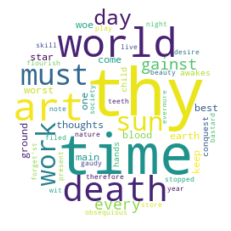

Counter({'in': 21, 'with': 19, 'but': 13, 'nor': 12, 'by': 11, 'me': 7, 'then': 7, 'thou': 6, 'that': 5, 'and': 5, 'much': 5, 'yet': 5, 'of': 4, 'so': 4, 'what': 4, 'for': 4, 'all': 4, 'have': 4, 'this': 3, 'it': 3, 'are': 3, 'not': 3, 'which': 3, 'thee': 3, 'like': 3, 'let': 3, 'cunning': 3, 'none': 3, 'come': 2, 'how': 2, 'rage': 2, 'recompense': 2, 'releasing': 2, 'fears': 2, 'those': 2, 'hast': 2, 'grace': 2, 'cheater': 2, 'hold': 2, 'look': 2, 'him': 2, 'want': 2, 'more': 2, 'neither': 2, 'watch': 2, 'proves': 2, 'glory': 2, 'elsewhere': 2, 'antiquity': 2, 'both': 2, 'i': 2, 'shall': 2, 'they': 1, 'aye': 1, 'pomp': 1, 'bequest': 1, 'lest': 1, 'limbs': 1, 'princes': 1, 'forgetful': 1, 'youth': 1, 'thus': 1, 'dart': 1, 'having': 1, 'thrivers': 1, 'fortune': 1, 'looked': 1, "what's": 1, 'supposed': 1, 'moon': 1, 'determination': 1, 'is': 1, 'farther': 1, 'engrossed': 1, 'nightly': 1, 'than': 1, 'still': 1, 'rising': 1, 'profaned': 1, 'heaven': 1, 'leaves': 1, 'eternity': 1, 'now': 1,

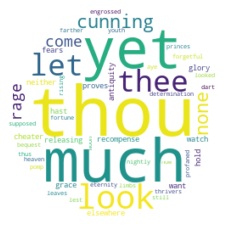

Counter({'and': 44, 'to': 20, 'are': 9, 'the': 7, 'thus': 6, 'that': 4, 'his': 4, 'thing': 4, 'blushing': 4, 'one': 3, 'if': 3, 'doth': 3, 'how': 3, 'in': 3, 'when': 3, 'very': 2, 'best': 2, 'were': 2, 'bough': 2, 'wanton': 2, 'double-vantage': 2, 'servant': 2, 'attend': 2, 'past': 2, 'must': 2, 'nor': 2, 'saturn': 2, 'adieu': 2, 'keen': 2, 'hand': 2, 'i': 2, 'hath': 2, 'do': 2, 'o': 2, 'make': 2, 'could': 2, 'extremity': 2, 'disperse': 2, 'hungry': 1, 'succeeding': 1, 'necessary': 1, 'slight': 1, 'breach': 1, 'badges': 1, 'day': 1, 'got': 1, 'hue': 1, 'which': 1, 'check': 1, 'uttering': 1, 'white': 1, 'but': 1, 'eclipses': 1, 'thrive': 1, 'sin': 1, 'trespass': 1, 'from': 1, 'controlling': 1, 'would': 1, 'age': 1, 'eternity': 1, 'by': 1, 'child': 1, 'presents': 1, "world's": 1, 'wrinkle': 1, 'eternal': 1, 'ruminate': 1, 'die': 1, 'enlarged': 1, 'foot': 1, "time's": 1, 'enough': 1, 'down': 1, 'sweet': 1, 'universe': 1, 'knife': 1, 'what': 1, 'for': 1, 'shadow': 1, 'can': 1, 'give': 1, '

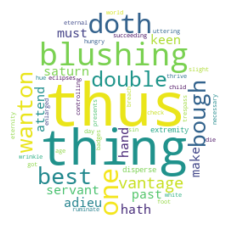

In [ ]:
# code adapted from wordcloud, to count words

n_states = len(hmm.A)
obs_map_r = obs_map_rev
wordclouds_mod = []
# For each state, get a list of observations that have been emitted
# from that state.
obs_count = []
for i in range(n_states):
    obs_lst = np.array(flat_emiss)[np.where(np.array(flat_st) == i)[0]]
    obs_count.append(obs_lst)

# For each state, count the words
for i in range(n_states):
    obs_lst = obs_count[i]
    sentence = [obs_map_r[j] for j in obs_lst]
    sentence_str = ' '.join(sentence)
    print(Counter(sentence))
    wordcloud = text_to_wordcloud(sentence_str)#title=statex)
    wordclouds_mod.append(wordcloud)

In [ ]:
#modified function to use our sonnet generation
def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = wordclouds_mod #states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = flat_emiss, flat_st#hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


Animating...


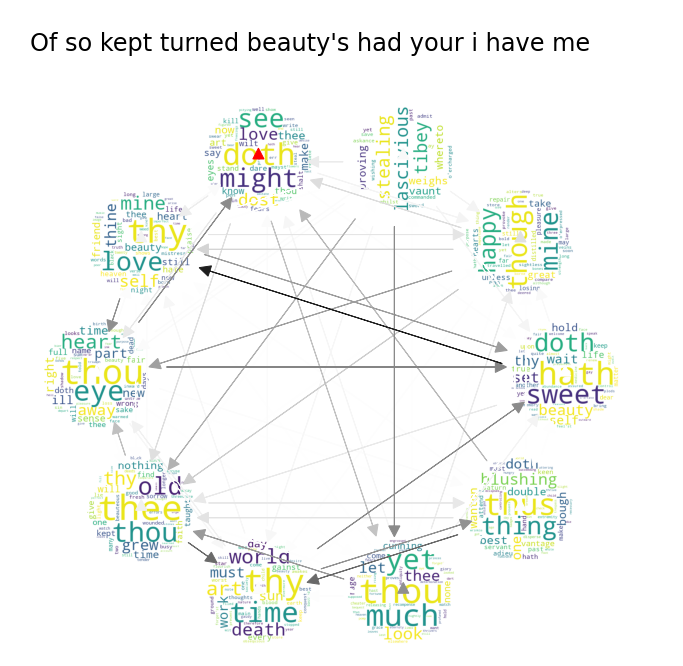

In [ ]:
from IPython.display import HTML
anim = animate_emission(hmm, obs_map, M=10)
HTML(anim.to_html5_video())